## SPUR Densification Survey- NLP Sentiment Analysis
author: Emily Robitschek

### Background information on survey: 
This survey was conducted by the SPUR group at ETH: https://spur.ethz.ch/
-(add more info)

### Hypothesis/Research question: 
Can we use the open text field responses from densification surveys to infer something about the motivations and emotions behind why individuals responded the way they did to the densification survey?

In [30]:
## Package imports
import os
import glob
import time

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict
import contractions
import spacy
nlp=spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
## Read in data
survey_responses_filepath = '../../../data/Densification_Survey/Chicago_original.csv' #lets work with the data from Chicago first
survey_response_df = pd.read_csv(survey_responses_filepath)
survey_response_df.head()

/Users/emilyrobitschek/opt/anaconda3/envs/giz_nlp_env_v1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,5,9,10,11,12,13,14,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,41,42,43,44,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,69,70,71,72,75,76,77,78,80,81,82,83,86,87,88,89,91,92,93,94,99,100,101,102,113,114,115,116,123,124,125,126,134,135,136,137,142,143,144,145,150,151,152,153,162,163,164,165,166,167,168,169,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,191,192,193,194,198,199,200,201,205,206,207,208,212,213,214,215,219,220,221,222,224,225,226,227,228,229,230,231,232,233,234,237,238,239,240,242,243,244,245,248,249,250,251,253,254,255,256,257,259,260,261,262,263,265,266,267,268,270,271,272,273,275,276,277,278,279,282,283,284,285,287,288,289,290,291,292,293,294,295,296,298,299,300,301,302,303,304,305,306,308,309,310,311,313,314,315,316,318,319,320,321,324,325,326,327,329,330,331,332,334,335,336,337,3

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,cintid,ProjectToken,pid,psid,basic,gc,term,age,projectLocation,LS
0,Anfangsdatum,Enddatum,Antworttyp,IP-Adresse,Aktueller Stand,Dauer (in Sekunden),Beendet,Erfassungsdatum,Antwort-ID,Nachname des Empfängers,...,cintid,ProjectToken,pid,psid,basic,gc,term,age,projectLocation,LS
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""cintid""}","{""ImportId"":""ProjectToken""}","{""ImportId"":""pid""}","{""ImportId"":""psid""}","{""ImportId"":""basic""}","{""ImportId"":""gc""}","{""ImportId"":""term""}","{""ImportId"":""age""}","{""ImportId"":""projectLocation""}","{""ImportId"":""LS""}"
2,2021-02-18 05:46:05,2021-02-18 05:59:36,IP-Adresse,172.221.89.193,100,810,Richtig,2021-02-18 05:59:39,R_2dAqH8oUCTPTMfN,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,25-34,Southwest Side,{Invalid Expression}
3,2021-02-18 06:05:55,2021-02-18 06:11:22,IP-Adresse,76.236.119.37,100,327,Richtig,2021-02-18 06:11:23,R_2X1HpxcUtZEpWYk,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,25-34,Far Southwest Side,{Invalid Expression}
4,2021-02-18 06:18:04,2021-02-18 06:23:04,IP-Adresse,73.111.29.206,100,300,Richtig,2021-02-18 06:23:05,R_10PI5FKTTlId8Ec,NaN,...,NaN,NaN,NaN,NaN,23350,1,NaN,18-24,South Side,{Invalid Expression}


We can immediately see that the first two rows after the header include the column names in German and then the importids. I will skip these first two rows, which also fixes most of the "mixed data types" errors for the columns.

In [13]:
#load dataframe without rows 1 and 2 
survey_response_df = pd.read_csv(survey_responses_filepath, skiprows=[1,2])
survey_response_df.head()

#examine column names for clues as to where the open text field columns might be: 
list(survey_response_df.columns)
survey_response_df.iloc[:, 220:]

/Users/emilyrobitschek/opt/anaconda3/envs/giz_nlp_env_v1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (253,259,275,375,503) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Q12.5_Last Click,Q12.5_Page Submit,Q12.5_Click Count,Q12.6,Q12.7_First Click,Q12.7_Last Click,Q12.7_Page Submit,Q12.7_Click Count,Q13.2,Q13.3,...,cintid,ProjectToken,pid,psid,basic,gc,term,age,projectLocation,LS
0,5.302,6.227,8.0,Great deal,7.102,7.102,14.701,1.0,2012.0,2012.0,...,NaN,NaN,NaN,NaN,23350,1.0,NaN,25-34,Southwest Side,{Invalid Expression}
1,5.234,6.439,5.0,Goo,0.825,0.825,3.258,1.0,1994.0,1997.0,...,NaN,NaN,NaN,NaN,23350,1.0,NaN,25-34,Far Southwest Side,{Invalid Expression}
2,5.018,5.883,7.0,I’m not yo I’m not talking to you,0.852,0.852,4.523,1.0,2011.0,2005.0,...,NaN,NaN,NaN,NaN,23350,1.0,NaN,18-24,South Side,{Invalid Expression}
3,5.681,6.385,6.0,It is the way it is,18.401,18.401,28.218,1.0,2008.0,2008.0,...,NaN,NaN,NaN,NaN,23350,1.0,NaN,35-44,Northwest Side,{Invalid Expression}
4,15.332,16.375,11.0,Because it would be more far to people that do...,0.025,8.444,29.318,3.0,1999.0,1999.0,...,NaN,NaN,NaN,NaN,23350,1.0,NaN,18-24,West and Near West Side,{Invalid Expression}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.504890e+09,A3BXt2ul1uc5T3apQbBd1g**,23350,NaN,NaN,55+,NaN,NaN
3412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23350,NaN,NaN,55+,NaN,NaN
3413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23350,NaN,NaN,NaN,NaN,NaN
3414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23350,NaN,NaN,55+,NaN,NaN


In [25]:
## Explore data and find open text field section
survey_text_answered = survey_response_df.dropna(subset=['Q12.6'])
survey_text_answered.head()
print(len(survey_text_answered))
for i in range(0, len(survey_text_answered)):
    try:
        print(survey_text_answered['Q12.6'][i])
    except KeyError: 
        pass

1914
Great deal
Goo
I’m not yo I’m not talking to you 
It is the way it is
Because it would be more far to people that don't have much
I choose proposal 2 because you offered me better things than proposal 1. 
Mhmmm girl
Because I felt like it wouldn’t be good enough for us 
I don't know
no comment
nothing 
yes
Ttyh
agree stong
Nothing to say 
I I prefer the lower density idea, but also mixed use with restaurants, cafes,etc. because I think it would draw other people from the surrounding communities more often as opposed to crafts or just apartments. Would also be more beneficial to residents of that neighborhood.
Not sure 
Yes
Whatever one sounds better
My positions are better 
This is Good Survey.
I don’t want the density to double!!
Yo yo bro I don’t know why 
Too many legalities
I like it 
Generally, I didn't agree with the subsidized housing issue.
Yes I love you too and miss you
Had to pick one
Because some are great
None
It's only logical to go by the decisios I made based on wh

### Intitial thoughts (Oct. 14, 2021)
Based on the responses, I am seeing several things: 

1) The response length varies greatly, with shorter responses more often (but not always) being "throw away" responses that are: 
>Either somewhat random (e.g. "Fyfgfx" or "Bzsbsnsbsn") or 
>unrelated to the survey or displaying a sort of apathetic/lackadiasical attitude (or maybe they were just tired of filling out the survey at that point - hard to say haha. (e.g. "Idk", "Nope", "Favor", "Nigh", "40", "I’m not yo I’m not talking to you"). 

However, the fact there are these patterns might be informative in and of themselves if they relate reliably to certain survey responses. (They also speak to core issues potentially like lack of trust or lack of knowledge, although they are confounded/hard to infer motivations behind them).

2) Even in substantive responses, the spelling isnt necessarily great so we should keep that in mind. 
>(e.g. "Because it would be more far to people that don't have much") - this person clearly meant "fair" not "far". or "I think the 10 percent is to high of a yearly increase" - this person clearly meant "too" not "to"

3) This is going to be hard/may not pull out anything reliably interesting 

4) May be interesting to see if response patterns map to particular neighborhoods

Goo
nothing 
yes
Ttyh
Not sure 
Yes
None
yes 
None 
yes
yes
40
Good
good
Nigh
Good 
good
Fyfgfx
ok
Idk
good
Favor
Nope
 N/A
5
Idk
no
The rent
very good
Good
Nothing
yes 
Climate 
Idk
no reason
Opinión 
ª
Yea
good one
no coment
N/a
No
Na
Idk
Yes 
good
Tjtkyky
Yes
Condo 
Great
Idc
No
Great
Parkash
Good
yes
its cool
THX
N/a
yes
okey
No
dont now
none
good very
na
Good 
na
yes
Good
None 
Yes like
None
very good
investors
ok
Ok
h8h
like
no
Na 
i like it
good
none
No
like
Nothing 
No thanks
in favor
idk
No
Savor
neutral
Nothing
Nty
Cool
Good
10
Nothing
Idk wjy
Nature
yes
na
idk
None
2
N/A 
 
LIKE
Good 
KJJJJJJJ
none
None 
ok
2
amazon
Yes
very good
Yes 
Yes
No
1
Na
Not sure
No
None
KFS
i like it
Grateful 
good
like
Ok
good 
None 
very good
good
yes 
Rent
very nice
Not sure
Good
Idk
na
idk
no
yes
Sjsj
ndsu
Very good
mo
No
None 
good
Costs
Not,sure
Vf
Meow 
All
Gfdsdfg
Good
Hi
None
very good
nothing
Sizing
nothing
Favor
none
no 
Good
Jon
Hfufi
Yes
Very good
cool
jd
None 
amazing
No
Nothing
No
ki

Text(0.5, 1.0, 'Distribution of character length of short-response for survey for Chicago')

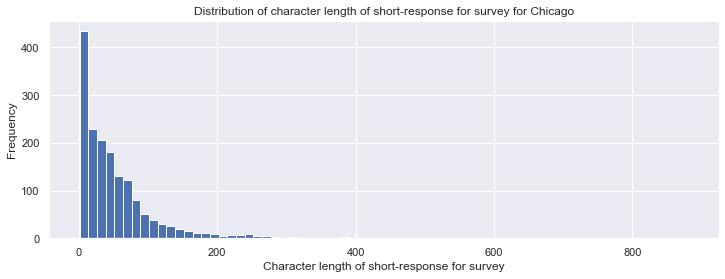

In [57]:
## Look at some of the responses for short character lengths
response_char_length = []
for i in range(0, len(survey_text_answered)):
    try:
        #print(survey_text_answered['Q12.6'][i])
        char_length = len(survey_text_answered['Q12.6'][i])
        if char_length < 10: 
            print(survey_text_answered['Q12.6'][i])
        #print(char_length)
        response_char_length.append(char_length)
    except KeyError: 
        pass
    
## Plot distribution of length of responses
plt.rcParams["figure.figsize"] = (12,4)
#sns.set(rc={'figure.figsize':(8,3)})
plt.hist(x=response_char_length, bins=70)
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey for Chicago")
plt.title(title)

In [ ]:
## Preprocess data 
# cut out short responses for now (<10 maybe? or <20, although some have some interesting words like rent or no or yes or good)
# 



In [ ]:
## Hugging Face? 

In [ ]:
## Sentiment analysis

In [ ]:
## Topic analysis

In [ ]:
## Mapping preferences in the different cities
#https://plotly.com/python/choropleth-maps/